In [193]:
# Warning ! You need to install geopandas on anaconda first
import os
import pandas as pd
import numpy as np
import json
import random
import geopandas as gpd
import folium
import math
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from haversine import haversine, Unit

### General cleaning of the dataset

In [91]:
fname = "./BikePaths/reseau_cyclable_2018_c.geojson"

bp = gpd.read_file(fname)

bp.head(3)

ID  ID_TRC_GEO  TYPE_VOIE  TYPE_VOIE2  LONGUEUR  NBR_VOIE SEPARATEUR  \
0  8998.0   1230109.0        4.0         0.0      90.0       2.0          M   
1     2.0         0.0        5.0         0.0      20.0       2.0       None   
2     3.0   1623974.0        1.0         0.0      36.0       2.0       None   

  SAISONS4 PROTEGE_4S Ville_MTL                                NOM_ARR_VI  \
0      OUI        OUI       OUI                     Le Plateau-Mont-Royal   
1      NON        NON       OUI  Rivi�re-des-Prairies�Pointe-aux-Trembles   
2      NON        NON       OUI  Rivi�re-des-Prairies�Pointe-aux-Trembles   

                                            geometry  
0  (LINESTRING Z (-73.59024203982732 45.532589280...  
1  (LINESTRING Z (-73.49679478102101 45.695741649...  
2  (LINESTRING Z (-73.57344998170396 45.658526272...

In [92]:
print(bp.Ville_MTL.unique())

['OUI' 'NON']


In [93]:
bp = bp[bp['Ville_MTL']=='OUI']
bp = bp.reset_index(drop=True)
bp = bp.drop(columns=['ID', 'ID_TRC_GEO', 'TYPE_VOIE', 'TYPE_VOIE2', 'SEPARATEUR', 'SAISONS4', 'PROTEGE_4S', 'Ville_MTL'])

In [94]:
bp.head(3)

LONGUEUR  NBR_VOIE                                NOM_ARR_VI  \
0      90.0       2.0                     Le Plateau-Mont-Royal   
1      20.0       2.0  Rivi�re-des-Prairies�Pointe-aux-Trembles   
2      36.0       2.0  Rivi�re-des-Prairies�Pointe-aux-Trembles   

                                            geometry  
0  (LINESTRING Z (-73.59024203982732 45.532589280...  
1  (LINESTRING Z (-73.49679478102101 45.695741649...  
2  (LINESTRING Z (-73.57344998170396 45.658526272...

### Informations about the global dataset

In [95]:
mean_length = bp.LONGUEUR.mean()
print("Mean length of a bike path : ", np.round(mean_length, 2), " m")
sum_length = bp.LONGUEUR.sum()
print("Cumulative length of all bike paths : ", sum_length, " m")

Mean length of a bike path :  133.5  m
Cumulative length of all bike paths :  752779.0  m


### Ajout des distances individuelles entre les points

In [96]:
bp['distances'] = bp.apply(lambda x: np.array([]),axis=1)

In [97]:
Recompute_densities = False
if Recompute_densities:
    for k in range(len(bp)):
        distances = []
        for l in range(len(bp['geometry'][k])):
            subdistances = np.array([])
            for m in range(len(bp['geometry'][k][l].xy[0])-1):
                #distances[l] = np.append(distances[l], haversine((x.latitude_start,x.longitude_start),(x.latitude_end,x.longitude_end)))
                subdistances = np.append(subdistances, 1000*haversine((bp['geometry'][k][l].xy[1][m], bp['geometry'][k][l].xy[0][m]),(bp['geometry'][k][l].xy[1][m+1], bp['geometry'][k][l].xy[0][m+1])))
            distances.append(subdistances)
        bp['distances'][k] = np.array(distances)

C:\Users\quent\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [100]:
bp = pd.read_pickle("./BikePaths/bike_paths_with_computed distances")

In [102]:
bp.head(3)

LONGUEUR  NBR_VOIE                                NOM_ARR_VI  \
0      90.0       2.0                     Le Plateau-Mont-Royal   
1      20.0       2.0  Rivi�re-des-Prairies�Pointe-aux-Trembles   
2      36.0       2.0  Rivi�re-des-Prairies�Pointe-aux-Trembles   

                                            geometry              distances  
0  (LINESTRING Z (-73.59024203982732 45.532589280...  [[89.74675564772875]]  
1  (LINESTRING Z (-73.49679478102101 45.695741649...  [[20.02003601877969]]  
2  (LINESTRING Z (-73.57344998170396 45.658526272...  [[35.57510452716641]]

### Bicycle path density in a square

In [103]:
def isincluded(x, y, a, b, da, db): # Attention ! da and db must be positive
    "Determines whether a point lies within the square defined by the values a, b, da and db."
    if abs(2*x - 2*a - da) <= da:
        if abs(2*y - 2*b - db) <= db:
            return 1
    return 0

In [104]:
def calculate_truncated_distance(x1, y1, x2, y2, a, b, da, db, d0, d1): # Attention ! da and db must be positive
    "For two points where one is inside the square and one is outside the square, "
    "calculate the length of the bike path portion inside the square."
    # Case where the first point is in the square
    if ((d0 == 1) and (d1 ==0)):
        if x1==x2:
            if y2<b:
                xt, yt = x1, b
            else:
                xt, yt = x1, b + db
        elif y1==y2:
            if x2<a:
                xt, yt = a, y1
            else:
                xt, yt = a + da, y1
        else:
            # Case y2 < b (under the square)
            if y2 < b:
                xtest = (x2-x1)*(b-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b
            # Case y2 > b + db (above the square)
            elif y2 > b+db:
                xtest = (x2-x1)*(b+db-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b+db
            # Case y in the range(b, b+db)
            else:
                if x2 <a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                else: # Case x2>a+da
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
        return  1000*haversine((y1,x1),(yt,xt))
    elif ((d0 == 0) and (d1 ==1)):
        return calculate_truncated_distance(x2, y2, x1, y1, a, b, da, db, d1, d0)
    else:
        return(0.)

### Example of calculation on a rectangle

In [105]:
### Definition of the rectangle
# Bottom left corner
b, a = 45.534745, -73.615292
# Top right corner : 45.549819, -73.583975
db = 45.549819 - b
da = -73.583975 - a

In [106]:
square = [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]]
m_bike = folium.Map([45.54,-73.6], tiles='cartodbpositron', zoom_start=14)
folium.PolyLine(square, color="red", weight=2.5, opacity=1).add_to(m_bike)
m_bike

In [107]:
def extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1): # Attention ! da and db must be positive
    "For two points where one is inside the square and the other outside, "
    "returns the point at the intersection between the edges of the square and the segment of the two points."
    # Case where the first point is in the square
    if ((d0 == 1) and (d1 ==0)):
        if x1==x2:
            if y2<b:
                xt, yt = x1, b
            else:
                xt, yt = x1, b + db
        elif y1==y2:
            if x2<a:
                xt, yt = a, y1
            else:
                xt, yt = a + da, y1
        else:
            # Case y2 < b (under the square)
            if y2 < b:
                xtest = (x2-x1)*(b-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b
            # Case y2 > b + db (above the square)
            elif y2 > b+db:
                xtest = (x2-x1)*(b+db-y1)/(y2-y1) + x1
                if xtest < a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                elif xtest > a + da:
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
                else : 
                    xt, yt = xtest, b+db
            # Case y in the range(b, b+db)
            else:
                if x2 <a:
                    xt, yt = a, (y2-y1)*(a-x1)/(x2-x1) + y1
                else: # Case x2>a+da
                    xt, yt = a+da, (y2-y1)*(a+da-x1)/(x2-x1) + y1
        return  [xt,yt]
    elif ((d0 == 0) and (d1 ==1)):
        return extremity_points(x2, y2, x1, y1, a, b, da, db, d1, d0)
    else:
        raise Error

In [108]:
### Records the portions of bicycle paths in the rectangle.

roads_in_the_square = []
for k in range(len(bp['geometry'])):
    for l in range(len(bp['geometry'][k])): # l et k sont les id d'un chemin simple
        # Ici, on a un chemin en considération
        subline_in_square = []
        for i in range(len(bp['geometry'][k][l].xy[0])-1): # i est l'id du point sur ce chemin
            x1, y1, x2, y2 = bp['geometry'][k][l].xy[0][i], bp['geometry'][k][l].xy[1][i] , bp['geometry'][k][l].xy[0][i+1], bp['geometry'][k][l].xy[1][i+1]
            d0, d1 = isincluded(x1, y1, a, b, da, db) , isincluded(x2, y2, a, b, da, db)
            if d0+d1==2: # Si les deux points sont dans le carré, on ajoute le premier
                subline_in_square.append([y1, x1])
            elif d1==1: # Si seul le deuxième point est dans le carré, on ajoute l'intersection seulement
                #print(extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1))
                [xt, yt] = extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1)
                subline_in_square.append([yt, xt])
            elif d0==1: # Si seul le premier point est dans le carré, on ajoute l'intersection et le premier point
                [xt, yt] = extremity_points(x1, y1, x2, y2, a, b, da, db, d0, d1)
                subline_in_square.append([y1, x1])
                subline_in_square.append([yt, xt])
        if d1 == 1: # On regarde si le dernier point de la ligne doit être finalement ajouté ou non
            subline_in_square.append([y2, x2])
        if len(subline_in_square)!=0:
            roads_in_the_square.append(subline_in_square)

In [109]:
square = [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]]
m_bike = folium.Map([45.54,-73.6], tiles='cartodbpositron', zoom_start=14)
folium.PolyLine(square, color="red", weight=2.5, opacity=1).add_to(m_bike)
for i in range(len(roads_in_the_square)):
    folium.PolyLine(roads_in_the_square[i], color='blue', weight=2.5, opacity=1).add_to(m_bike)
m_bike

### Calculation of the total distance in the rectangle

In [110]:
total_distance_in_the_square = 0.
for k in range(len(bp['geometry'])):
    for l in range(len(bp['geometry'][k])): # l et k sont les id d'un chemin simple
        for i in range(len(bp['geometry'][k][l].xy[0])-1): # i est l'id du point sur ce chemin
            x1, y1, x2, y2 = bp['geometry'][k][l].xy[0][i], bp['geometry'][k][l].xy[1][i] , bp['geometry'][k][l].xy[0][i+1], bp['geometry'][k][l].xy[1][i+1]
            d0, d1 = isincluded(x1, y1, a, b, da, db) , isincluded(x2, y2, a, b, da, db)
            if d0+d1==2: # Si les deux points sont dans le carré, on ajoute le premier
                total_distance_in_the_square += bp['distances'][k][l][i]
            elif ((d1==1) or (d0==1)): # Si seul le deuxième point est dans le carré, on ajoute l'intersection seulement
                total_distance_in_the_square += calculate_truncated_distance(x1, y1, x2, y2, a, b, da, db, d0, d1)

In [111]:
total_distance_in_the_square

18567.34398641432

### Comparison with the distance of the previous algorithm

In [112]:
compared_distance_in_the_square = 0.
for i in range(len(roads_in_the_square)):
    for j in range(len(roads_in_the_square[i])-1):
        compared_distance_in_the_square += 1000*haversine((roads_in_the_square[i][j][0],roads_in_the_square[i][j][1]),(roads_in_the_square[i][j+1][0],roads_in_the_square[i][j+1][1]))


In [113]:
compared_distance_in_the_square

18567.34398641432

We are indeed achieving the same result.

### Divide a big square into smaller ones and start the analysis

In [114]:
def compute_density_in_squares(x1,y1,x2,y2,n_x_squares):
    '''(x1,y1) represents the point at the bottom left and (x2,y2) the point at the top right
    The n_x_squares number represents the number of squares between x1 and x2. 
    The length of a square according to x will then be used to calculate the number of squares according to y. '''
    dx = abs(x2-x1)/n_x_squares # = dy
    n_y_squares = math.ceil(abs(y2-y1)/dx)
    density_matrix = np.zeros((n_x_squares,n_y_squares))
    a, b = x1, y1
    for i in range(n_x_squares):
        for j in range(n_y_squares):
            for k in range(len(bp['geometry'])):
                for l in range(len(bp['geometry'][k])):
                    for m in range(len(bp['geometry'][k][l].xy[0])-1):
                        xp1, yp1, xp2, yp2 = bp['geometry'][k][l].xy[0][m], bp['geometry'][k][l].xy[1][m] , bp['geometry'][k][l].xy[0][m+1], bp['geometry'][k][l].xy[1][m+1]
                        d0, d1 = isincluded(xp1, yp1, a, b, dx, dx) , isincluded(xp2, yp2, a, b, dx, dx)
                        if d0+d1==2: # If the two points are in the square
                            density_matrix[i,j] += bp['distances'][k][l][m]
                        elif ((d1==1) or (d0==1)): # If only one point is in the square
                            density_matrix[i,j] += calculate_truncated_distance(xp1, yp1, xp2, yp2, a, b, dx, dx, d0, d1)
            b+=dx
        a += dx
        b = y1
    for i in range(n_x_squares):
        for j in range(n_y_squares):
            density_matrix[i,j] = density_matrix[i,j]/((haversine((y1, x1), (y1+dx, x1+dx)))**2)
    return density_matrix

In [116]:
# density_matrix_test = compute_density_in_squares(-73.662333, 45.470386, -73.534273, 45.571657, 10)

In [117]:
# Loading previous result

density_matrix_test = np.array([[   0.        ,    0.        ,    0.        ,   15.89333367,
           0.        ,    0.        , 1831.37103444,  760.9496764 ],
       [ 325.91864594,  607.82249553,  402.55594107,    0.        ,
         458.60720575,  486.66586539, 1804.97789517, 1040.38438051],
       [1200.03785482,  988.64313558,  803.27878942,  317.75461762,
        1026.16893779, 1804.05003034,  868.81719987, 1346.43251843],
       [ 748.58840031,  128.37707621,  924.90397643,  865.78998026,
         292.5099289 , 2597.36025776,  831.16538798,  419.53643211],
       [ 696.6549423 ,  105.83030859,  464.91099804, 1112.99580186,
        2149.41216313, 2265.98327835, 1440.92925419,  317.40214762],
       [ 503.43596322,   34.42215485, 1728.48237621, 2120.97759095,
        2475.89595888, 1720.20413968, 2674.76342619,  676.25795522],
       [1686.27369518,  511.15319819, 1160.10354596, 3015.30741535,
        2476.38055347, 2992.32816772, 2489.01619164, 2451.0126901 ],
       [1882.84258311, 1063.98418081,  882.1530329 , 1447.47836826,
        1694.54853976, 1764.72761934,  934.85697661, 1841.40052721],
       [1002.7295195 , 1662.00198248, 1546.52643377, 1247.18203521,
        1606.89500269,  899.91636181, 1858.00776144, 1387.02945754],
       [ 637.19371826,  307.61141929,  858.04126216,  187.64247536,
         693.61227061, 1688.59445133, 2182.55238712,  452.70474823]])

### Preparing a chloropleth

In [118]:
# Match each item in the density_matrix list with its corresponding square.

def edges_of_the_squares(x1,y1,x2,y2,n_x_squares):
    '''(x1,y1) represents the point at the bottom left and (x2,y2) the point at the top right
    The n_x_squares number represents the number of squares between x1 and x2. 
    The length of a square according to x will then be used to calculate the number of squares according to y. '''
    dx = abs(x2-x1)/n_x_squares # = dy
    n_y_squares = math.ceil(abs(y2-y1)/dx)
    edges_matrix = np.array([[((y1+j*dx, x1+i*dx), (y1+j*dx, x1+i*dx+dx), (y1+j*dx+dx, x1+i*dx+dx), (y1+j*dx+dx, x1+i*dx), (y1+j*dx, x1+i*dx)) for j in range(n_y_squares)] for i in range(n_x_squares)])
    # Similarly to [[b, a], [b, a+da], [b+db, a+da], [b+db, a], [b, a]] above
    return edges_matrix

In [119]:
edges_matrix_test = edges_of_the_squares(-73.662333, 45.470386, -73.534273, 45.571657, 10)

In [120]:
for i in range(edges_matrix_test.shape[0]):
    for j in range(edges_matrix_test.shape[1]):
        for k in range(edges_matrix_test.shape[2]):
            edges_matrix_test[i,j,k,0], edges_matrix_test[i,j,k,1] = edges_matrix_test[i,j,k,1], edges_matrix_test[i,j,k,0]


In [121]:
id_list = [[]]
for j in range(edges_matrix_test.shape[1]):
    id_list[0].append(str(i)+"-"+str(j))
for i in range(1,edges_matrix_test.shape[0]):
    id_list.append([])
    for j in range(edges_matrix_test.shape[1]):
        id_list[i].append(str(i)+"-"+str(j))


In [122]:
def convert_to_geojson(data):
    dump = {}
    dump["type"] = "FeatureCollection"
    
    features = []
    for id, points in data :
        if points[0] != points[-1]:
            print("invalid points !", points)
        feature = {"id":id}
        feature["type"] = "Feature"
        feature["properties"] = {"id":id}
        feature["geometry"] = {"type":"Polygon", "coordinates":[points,]}
        features.append(feature)
    dump["features"] = features
    return json.dumps(dump)

id_and_squares = [(id_list[i][j], edges_matrix_test[i][j].tolist()) for j in range(edges_matrix_test.shape[1]) for i in range(edges_matrix_test.shape[0])]

montreal_squares = convert_to_geojson(id_and_squares)

In [123]:
distances_in_the_squares = pd.DataFrame({'id':np.array(id_list).flatten(), 'density':density_matrix_test.flatten()})

### Choropleth of the distances

In [124]:
m_bike = folium.Map([45.52,-73.6], tiles='cartodbpositron', zoom_start=12)

folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='BuPu',
    fill_opacity=0.4,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bike)


m_bike

In [125]:
m_bike.save("results/Bike_Path_Density_Chloropleth.html")

In [126]:
%%HTML
<iframe width="100%" height="350" src="results/Bike_Path_Density_Chloropleth.html"></iframe>

### HeatMap of bike turning points

In [127]:
data_pointsx = np.array([])
data_pointsy = np.array([])
for k in range(len(bp['geometry'])):
    for l in range(len(bp['geometry'][k])):
        data_pointsx = np.append(data_pointsx, bp['geometry'][k][l].xy[0])
        data_pointsy = np.append(data_pointsy, bp['geometry'][k][l].xy[1])
data_points = np.vstack((data_pointsy, data_pointsx)).T

In [128]:
geo_json_data = json.load(open("./BikePaths/reseau_cyclable_2018_c.geojson"))

In [129]:
m_bike_points = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(data_points, radius = 15, min_opacity = 0.6).add_to(m_bike_points)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bike_points)
m_bike_points

In [130]:
m_bike_points.save("results/Matching_Bike_Path_Density_Chloropleth_with_Point_Density.html")

These densities are well consistent with the point density for each road segment. However, we needed to calculate this density because the number of points can often differ from the length of a path: a circular path will have many more points than a long straight line.

### Comparison of the bike path density and the density of BIXI stations

In [248]:
stations = pd.read_csv('./BixiMontrealRentals/Stations_2019.csv', sep=',').set_index('code')

station_pointsx = np.array(stations.longitude.array)
station_pointsy = np.array(stations.latitude.array)
station_points = np.vstack((station_pointsy, station_pointsx)).T

m_bixi_bp = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bixi_bp)
HeatMap(station_points, radius = 12, min_opacity = 1).add_to(m_bixi_bp)
m_bixi_bp

In [131]:
# Comparison

In [132]:
fname = "./BusLines/stm_lignes_sig.shp"
busl = gpd.read_file(fname)

### Metro lines

In [133]:
m_metro = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_metro)
folium.GeoJson(busl[:9],name='route_name').add_to(m_metro)
m_metro

In [134]:
m_metro.save("results/Matching_Bike_Path_Density_Chloropleth_Metro_Lines.html")

### Bus lines

In [175]:
m_bus = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
folium.Choropleth(
    geo_data=montreal_squares,
    data=distances_in_the_squares,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Bike paths densities'
).add_to(m_bus)
folium.GeoJson(busl[10:491], style_function= lambda x :{'color': 'green','opacity':0.2}).add_to(m_bus)
m_bus

In [ ]:
m_bus.save("results/Matching_Bike_Path_Density_Chloropleth_Bus_Lines.html")

# Compute bike path density between two bixi stations

In [183]:
bixi_paths = pd.read_pickle("paths")
bixi_paths.head(3)

start_station_code  end_station_code  counts     duration  latitude_start  \
0                4000              4000     103  1173.126214       45.549598   
1                4000              4002       1  1864.000000       45.549598   
2                4000              5007       1  3585.000000       45.549598   

   longitude_start  latitude_end  longitude_end  distance  
0       -73.541874     45.549598     -73.541874  0.000000  
1       -73.541874     45.516937     -73.640483  8.496129  
2       -73.541874     45.523319     -73.520127  3.377533

In [184]:
bixi_paths = bixi_paths.sort_values(by="counts", axis=0)
bixi_paths = bixi_paths.dropna()
bixi_paths = bixi_paths[bixi_paths['distance']>0.]

In [187]:
bixi_subdata = bixi_paths[(bixi_paths['counts']>=500)].sample(200)

cut_counts_list = [0, 10, 20, 40, 100, 500]
for k in range(len(cut_counts_list)-1):
    bixi_subdata = pd.concat([bixi_subdata, bixi_paths[(bixi_paths['counts']>=cut_counts_list[k])&(bixi_paths['counts']<cut_counts_list[k+1])].sample(200)])

bixi_subdata = bixi_subdata.reset_index(drop=True)
bixi_subdata['bp_density'] = bixi_subdata.apply(lambda x: 0.,axis=1)
"""
for k in bixi_subdata.index:
    bixi_subdata['bp_density'][k] = compute_density_in_squares(bixi_subdata['longitude_start'][k],bixi_subdata['latitude_start'][k],bixi_subdata['longitude_end'][k],bixi_subdata['latitude_end'][k])
"""

"\nfor k in bixi_subdata.index:\n    bixi_subdata['bp_density'][k] = compute_density_in_squares(bixi_subdata['longitude_start'][k],bixi_subdata['latitude_start'][k],bixi_subdata['longitude_end'][k],bixi_subdata['latitude_end'][k])\n"

In [188]:
# After the analysis (around 2.5 hours to run)
bixi_subdata  = pd.read_pickle("./paths_with_bp_densities")

In [189]:
bixi_subdata

start_station_code  end_station_code  counts     duration  \
0                   6387              4000     540   367.100000   
1                   6727             10002    1015   398.568473   
2                   6136              6199     645   355.582946   
3                  10002              6732    1079   420.763670   
4                   6084              6043     639   377.895149   
...                  ...               ...     ...          ...   
1195                6115              6263     162   324.783951   
1196                7070              7047     148   534.952703   
1197                6184              6148     137   698.284672   
1198                6043              6036     362   765.817680   
1199                6165              6043     175  1395.880000   

      latitude_start  longitude_start  latitude_end  longitude_end  distance  \
0          45.546907       -73.551557     45.549598     -73.541874  0.811189   
1          45.484081       -73.560918     45.478228     -73.569651  0.941929   
2          45.527616       -73.589115     45.525931     -73.598839  0.780373   
3          45.478228       -73.569651     45.477923     -73.559038  0.828188   
4          45.495581       -73.553711     45.502060     -73.562950  1.018576   
...              ...              ...           ...            ...       ...   
1195       45.466914       -73.631704     45.471179     -73.627002  0.599462   
1196       45.479930       -73.555921     45.493909     -73.559507  1.579284   
1197       45.524673       -73.582550     45.527201     -73.564729  1.416421   
1198       45.502060       -73.562950     45.504242     -73.553469  0.777682   
1199       45.532514       -73.584811     45.502060     -73.562950  3.790566   

      bp_density  
0       2.580871  
1       2.547097  
2       3.047620  
3       2.111295  
4       3.448973  
...          ...  
1195    2.498055  
1196    2.679403  
1197    3.720692  
1198    3.269659  
1199    3.014836  

[1200 rows x 10 columns]

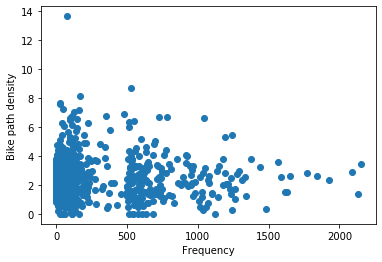

In [201]:
plt.scatter(bixi_subdata.counts, bixi_subdata.bp_density)
plt.ylabel('Bike path density')
plt.xlabel('Frequency')
plt.show()

In [246]:
bixi_subdata.counts.corr(bixi_subdata.bp_density)

-0.05794804683459805

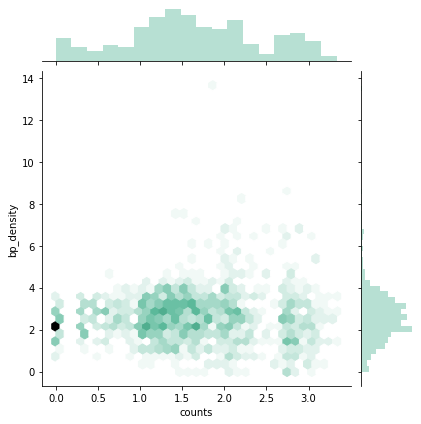

In [244]:
sns.jointplot(np.log10(bixi_subdata.counts), bixi_subdata.bp_density, kind='hex', color="#4CB391")
plt.show()

In [245]:
np.log10(bixi_subdata.counts).corr(bixi_subdata.bp_density)

0.017658752383032335

# Compare Bixi station locations with Metro and Bus locations

In [234]:
stations = pd.read_csv('./BixiMontrealRentals/Stations_2019.csv', sep=',').set_index('code')

station_pointsx = np.array(stations.longitude.array)
station_pointsy = np.array(stations.latitude.array)
station_points = np.vstack((station_pointsy, station_pointsx)).T

m_metro_2 = folium.Map([45.52,-73.6], tiles='stamentoner', zoom_start=12)
HeatMap(station_points, radius = 10, min_opacity = 0.8).add_to(m_metro_2)
folium.GeoJson(busl[:9],name='route_name', style_function= lambda x :{'color': 'red','opacity':3}).add_to(m_metro_2)
m_metro_2

In [235]:
m_metro_2.save("results/Matching_Bixi_Stations_HeatMap-with_Metro_Lines.html")